In [1]:
# load the deepforest prebuilt crown model and run it on a single image
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import rasterio


In [36]:
model = main.deepforest()

model.use_release()

## load the image
# image_path = get_data("OSBS_029.tif")
# image_path = "/Users/philblecher/Desktop/Github/BioAI/test_imgs/51.png"
image_path = "/Users/philblecher/Desktop/Github/BioAI/download_sat_image.tif"

# run the model
predictions = model.predict_tile(raster_path=image_path, return_plot=False, patch_size=100, patch_overlap=0.1)
predictions.head()
# plt.imshow(predictions)
# plt.show()



Reading config file: /Users/philblecher/opt/miniconda3/envs/deepforest/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/Users/philblecher/opt/miniconda3/envs/deepforest/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0:   4%|▎         | 29/784 [02:49<1:13:44,  0.17it/s]

/Users/philblecher/opt/miniconda3/envs/deepforest/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


TypeError: 'NoneType' object is not iterable

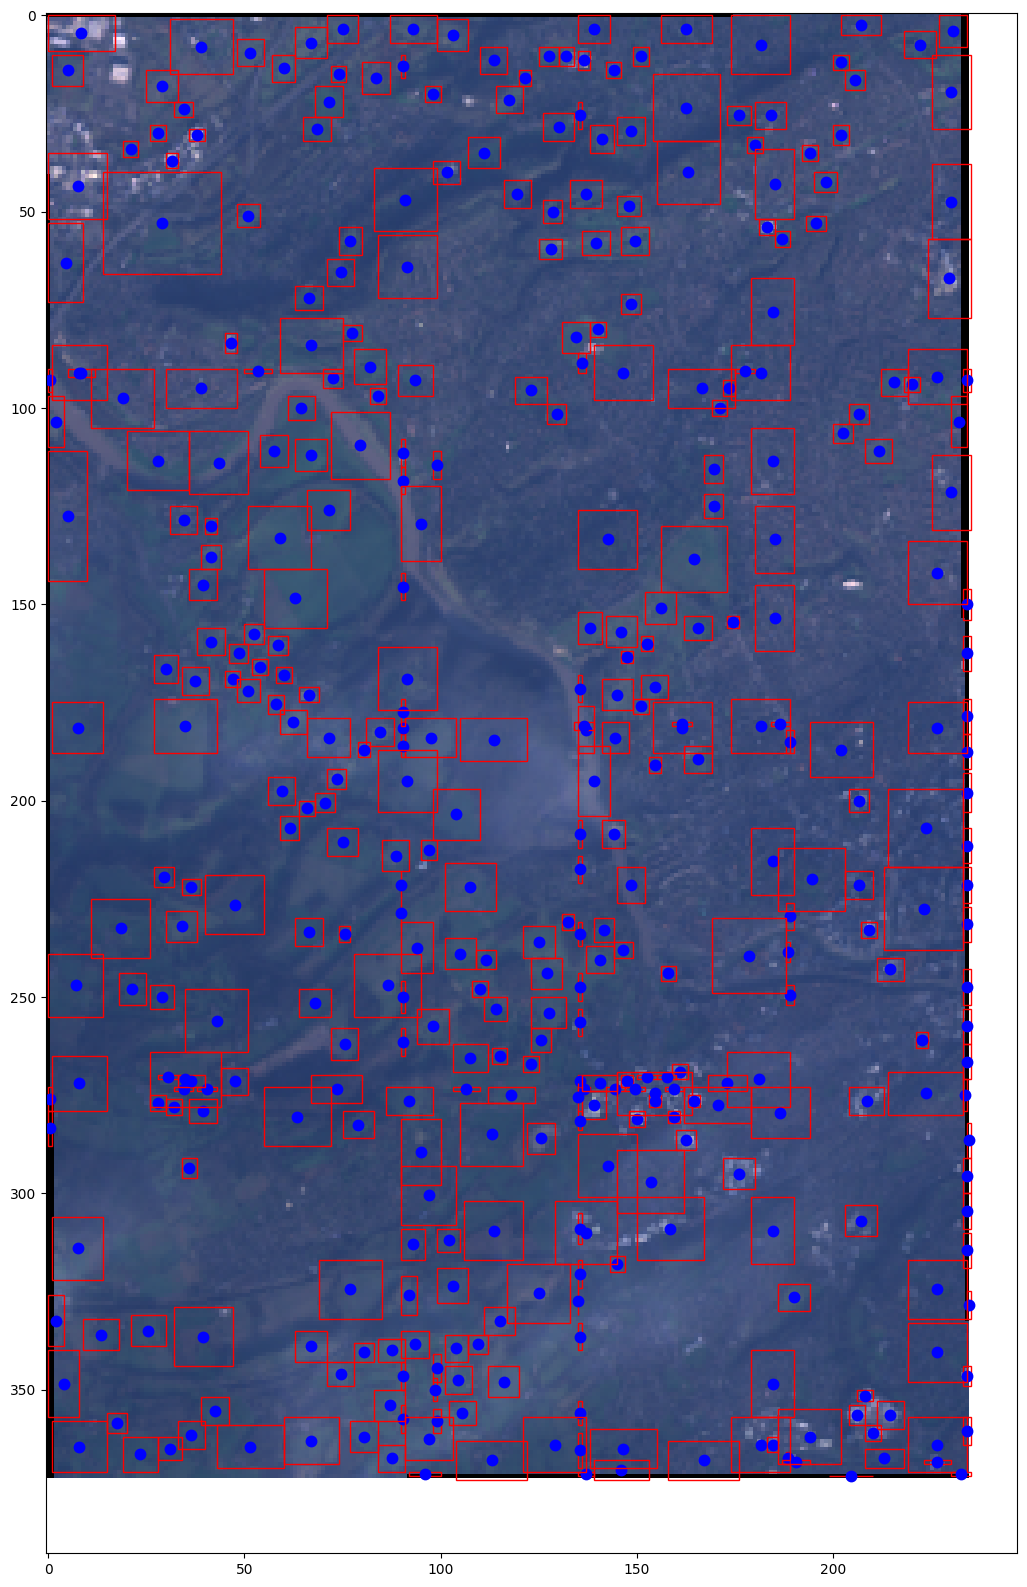

In [3]:
# plot the image .tif and the predictions
fig, ax = plt.subplots(figsize=(20, 20))

# open tif image
image = rasterio.open(image_path)
image = image.read()
image = np.moveaxis(image, 0, -1)
image = image.squeeze()
plt.imshow(image)

# plot the bounding boxes
for i in range(len(predictions)):
    x, y, w, h = predictions["xmin"][i], predictions["ymin"][i], predictions["xmax"][i], predictions["ymax"][i]
    rect = plt.Rectangle((x, y), w-x, h-y, fill=False, color="red")
    ax.add_patch(rect)
    # scatter points on the image, scale the scatter points fit the same scale as the image
    ax.scatter(predictions["xmin"][i] + (predictions["xmax"][i] - predictions["xmin"][i]) / 2,
                predictions["ymin"][i] + (predictions["ymax"][i] - predictions["ymin"][i]) / 2,   
                color="blue", linewidths=2.5, edgecolors="blue")


plt.show()


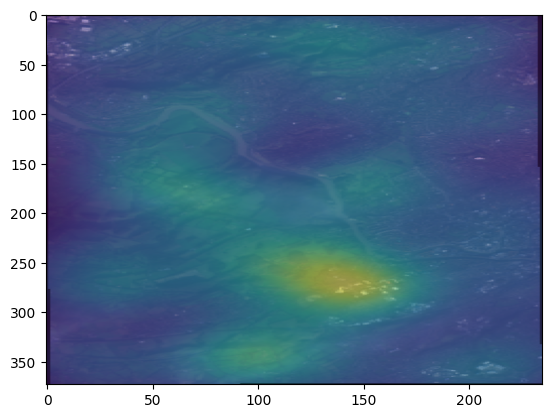

In [4]:
# transform the scatter into a density map
# create a grid of points
x_size = np.linspace(0, image.shape[1], image.shape[1])
y_size = np.linspace(0, image.shape[0], image.shape[0])
X, Y = np.meshgrid(x_size, y_size)
# create a density map
Z = np.zeros(X.shape)
for i in range(len(predictions)):
    x, y = (predictions["xmin"][i] + predictions["xmax"][i]) / 2, (predictions["ymin"][i] + predictions["ymax"][i]) / 2
    Z += np.exp(-((X - x)**2 + (Y - y)**2) / 1000) # the 1000 is a hyperparameter that controls the spread of the density map


fig, ax = plt.subplots()
ax.imshow(Z, aspect="auto")
ax.imshow(image, aspect="auto", alpha=0.5)
plt.show()


(373, 235, 1)
[[ 3.925707   4.536416   5.173542  ...  5.9259067  5.2681365  4.615087 ]
 [ 4.696229   5.4524384  6.243001  ...  6.717328   5.9245234  5.1581745]
 [ 5.322388   6.201561   7.120035  ...  7.194966   6.288309   5.436506 ]
 ...
 [ 6.1363506  6.9230375  7.6655984 ... 12.340549  11.4050865 10.344136 ]
 [ 5.5411882  6.2947316  7.0195837 ... 12.015242  11.034623   9.949878 ]
 [ 4.710043   5.3811746  6.035458  ... 10.940964  10.007618   8.990557 ]]


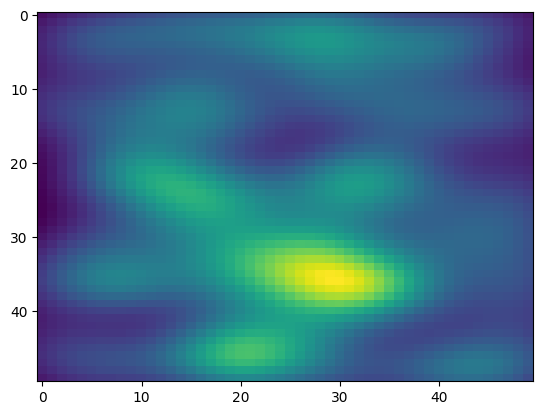

In [5]:
# transform the density map into an array of density values shape (m,n,1)
Z = Z.reshape(Z.shape[0], Z.shape[1], 1)
print(Z.shape)

# resize and interpolate the density map to the same number of pixels as the image as requested
rows = 50
cols = 50
Z = np.array(Image.fromarray(Z.squeeze()).resize((rows, cols)))
print(Z)

# normalize the density map
Z = Z / np.max(Z)

# plot the density map
fig, ax = plt.subplots()
ax.imshow(Z, aspect="auto")
plt.show()




In [6]:
print(Z.shape)

# save the density as a .h5 file
import h5py
with h5py.File("density.h5", "w") as f:
    f.create_dataset("density", data=Z)



(50, 50)


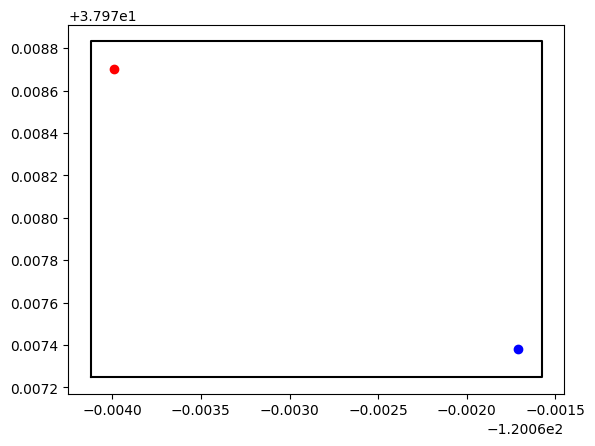

In [44]:
import ee
ee.Authenticate()

ee.Initialize()
# get the bounding box of the image

coord_A = ee.Geometry.Point( -120.06399, 37.97870)
coord_B = ee.Geometry.Point( -120.06171, 37.97738)
# create a bounding box that has a and b as two opposite corners of the rectangle
# the max and min of the coordinates are used to create the rectangle
# coord_A.getInfo().get("coordinates")[0]
lat_min = min(coord_A.getInfo().get("coordinates")[1], coord_B.getInfo().get("coordinates")[1])
lat_max = max(coord_A.getInfo().get("coordinates")[1], coord_B.getInfo().get("coordinates")[1])
lon_min = min(coord_A.getInfo().get("coordinates")[0], coord_B.getInfo().get("coordinates")[0])
lon_max = max(coord_A.getInfo().get("coordinates")[0], coord_B.getInfo().get("coordinates")[0])

# add a buffer to the bounding box
buffer = 0.1 * (lat_max - lat_min)
lat_min -= buffer
lat_max += buffer
lon_min -= buffer
lon_max += buffer

# plot a, b and the bounding box
fig, ax = plt.subplots()
ax.scatter(coord_A.getInfo().get("coordinates")[0], coord_A.getInfo().get("coordinates")[1], color="red")
ax.scatter(coord_B.getInfo().get("coordinates")[0], coord_B.getInfo().get("coordinates")[1], color="blue")
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min], [lat_min, lat_min, lat_max, lat_max, lat_min], color="black")
plt.show()

# make the bounding box a geometry object
bounding_box = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

# get box width and height
box_width = lon_max - lon_min
box_height = lat_max - lat_min



In [45]:
import requests

# get the satellite image
dataset = ee.ImageCollection("USDA/NAIP/DOQQ").filter(ee.Filter.date('2016-01-01', '2017-01-01')).mosaic()
true_color = dataset.select(['R', 'G', 'B'])
true_color_vis = {
    "bands": ['R', 'G', 'B'],
    "min": 0,
    "max": 255
}

# set centre
centre = bounding_box.centroid().getInfo().get("coordinates")

clipped_image = true_color.clip(bounding_box)

# get the image
# image = clipped_image.visualize(**true_color_vis)

# save the image locally as .tif


# Multi-band GeoTIFF file.
url = clipped_image.getDownloadUrl({
    'name': 'download_sat_image',
    'scale': 0.1,
    'format': 'GeoTIFF',
})

response = requests.get(url)
with open('download_sat_image.tif', 'wb') as fd:
  fd.write(response.content)



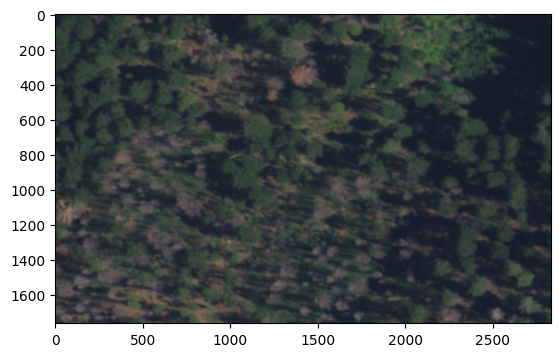

In [46]:
# view downloaded image
image = rasterio.open("download_sat_image.tif")
image = image.read()
image = np.moveaxis(image, 0, -1)
image = image.squeeze()
plt.imshow(image)

plt.show()

# # view downloaded jpg image
# image = Image.open("download_sat_image.jpg")
# image = np.array(image)
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# plt.show()


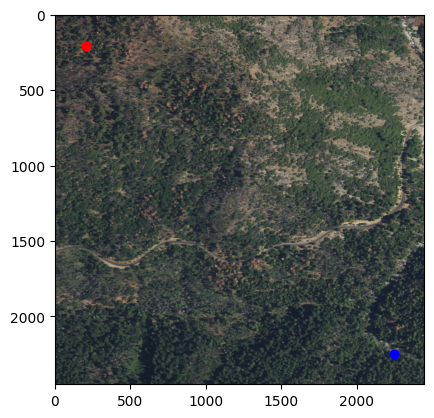

(204.16666666739204, 204.166666666304) (2245.833333332608, 2245.833333333696)


In [41]:
# overlay the lat, lon points on the image
fig, ax = plt.subplots()
ax.imshow(image)
ax.scatter((coord_A.getInfo().get("coordinates")[0] - lon_min) / box_width * image.shape[1], 
            (coord_A.getInfo().get("coordinates")[1] - lat_min) / box_height * image.shape[0], color="red")
ax.scatter((coord_B.getInfo().get("coordinates")[0] - lon_min) / box_width * image.shape[1],
            (coord_B.getInfo().get("coordinates")[1] - lat_min) / box_height * image.shape[0], color="blue")
plt.show()

# give the points as pixel coordinates
pixel_A = (coord_A.getInfo().get("coordinates")[0] - lon_min) / box_width * image.shape[1], (coord_A.getInfo().get("coordinates")[1] - lat_min) / box_height * image.shape[0]
pixel_B = (coord_B.getInfo().get("coordinates")[0] - lon_min) / box_width * image.shape[1], (coord_B.getInfo().get("coordinates")[1] - lat_min) / box_height * image.shape[0]
print(pixel_A, pixel_B)